Import relevent dependencies

In [84]:
import numpy as np 
import pandas as pd 
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib
matplotlib.use('PDF')
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

Choose the locations of interest. Run the Cycle_Car_preprocess.ipynb to visualize the locations on a map.

In [85]:
choice_cycle_sensor_id=10000210
choice_car_sensor_id=300099

Read the input data in to Dataframes

In [86]:
cycle_data=pd.read_csv('cycle_met.csv',sep=';',parse_dates=['TIME'])
car_data=pd.read_csv('car_met.csv',sep=';',parse_dates=['TIME'])

In [87]:
print(car_data['SENSOR_ID'].unique())
print(cycle_data['SENSOR_ID'].unique())

[300016 300099 300233 302257 300083]
[10000210 10000480 10000790]


Do the following
* Extract the target variable SUM and AVGSPEED and save them as y_count and y_speed
* Convert all the categorial variables that are string (WEEKDAY and MONTH) into integer codes
* Do a one-hot-encoding of the categorical variables (DIRECTION / LANE, MONTH, WEEKDAY and HOUR)
* Remove all the irrelevent columns (TIME, SENSOR_ID, STATION_ID, SUM, AVGSPEED) from the dataframes
* Save the resulting dataframe into feature matrix to be used in the machine learning algorithms

In [88]:
def process_car_data(data,sensor_id):
    data=car_data[data.SENSOR_ID == sensor_id]
    y_count = data['SUM'].values.reshape(-1,1)
    y_speed = data['AVGSPEED '].values.reshape(-1,1)
    data['WEEKDAY'] = pd.Categorical(data['WEEKDAY']).codes
    data['MONTH'] = pd.Categorical(data['MONTH']).codes
    data=pd.get_dummies(data,columns=['MONTH','HOUR','WEEKDAY'],
                            prefix=['month','hour','weekday'])
    data = data.drop(['TIME','SENSOR_ID','STATION_ID','SUM','AVGSPEED ','DIRECTION'],axis=1)
    X = data.values
    return X,y_count,y_speed

In [89]:
def process_cycle_data(data,sensor_id):
    data = data[data.SENSOR_ID == sensor_id]
    y_count = data['SUM'].values.reshape(-1,1)
    data['WEEKDAY'] = pd.Categorical(data["WEEKDAY"]).codes
    data['MONTH'] = pd.Categorical(data["MONTH"]).codes
    data=pd.get_dummies(data,columns=["LANE","MONTH","HOUR","WEEKDAY"],
                              prefix=["lane","month","hour","weekday"])
    data=data.drop(['TIME','SENSOR_ID','STATION_ID','SUM'],axis=1)
    X = data.values
    return X, y_count

In [90]:
def split_test_train_val(X,y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.1,random_state = 0)
    X_test, X_val,y_test,y_val =  train_test_split(X_test,y_test,test_size=0.1,random_state = 0)
    return X_train,X_test,X_val,y_train,y_test,y_val

In [91]:
def print_error(train,test,target_train,target_test,parameter):
    print("Mean squared error on training set using ",parameter,np.mean((train-target_train)**2))
    print("Mean squared error on test set using  ",parameter,np.mean((test-target_test)**2))

In [92]:
def predict(clf, input_features):
    prediction=clf.predict(input_features).reshape(-1,1)
    return prediction

In [93]:
def LR(X_train,X_test,y_train,y_test):
    from sklearn import linear_model
    clf = linear_model.LinearRegression()
    clf.fit(X_train, y_train)
    print_error(predict(clf,X_train),predict(clf,X_test),y_train,y_test,'LR')
    return clf

In [94]:
def RF(X_train,X_test,y_train,y_test,max_depth):
    from sklearn.ensemble import RandomForestRegressor
    max_depth = max_depth
    clf = RandomForestRegressor(max_depth=max_depth, random_state=2)
    clf.fit(X_train, y_train)    
    print("MSE on test data",mean_squared_error(predict(clf,X_test),y_test))
    print_error(predict(clf,X_train),predict(clf,X_test),y_train,y_test,'RF')
    return clf

In [95]:
def DT(X_train,X_test,y_train,y_test):
    from sklearn.tree import DecisionTreeRegressor
    clf = DecisionTreeRegressor()
    clf.fit(X_train,y_train)
    print_error(predict(clf,X_train),predict(clf,X_test),y_train,y_test,'DT')
    return clf

In [96]:
def ANN(X_train,X_test,y_train,y_test):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.utils import np_utils
    m,input_layer_size=X_test.shape
    hidden_layer_size = input_layer_size   
    clf = Sequential()
    clf.add(Dense(units = 30, kernel_initializer = 'uniform', 
                  activation = 'relu', input_dim = input_layer_size))
    clf.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
    clf.add(Dense(units = 1, kernel_initializer = 'normal'))
    clf.compile(loss='mean_squared_error', optimizer='adam')
    print("Shapes of y_test, y_prediction ",predict(clf,X_test).shape,y_test.shape)
    history=clf.fit(X_train, y_train, batch_size = 2000, epochs = 1000,verbose=0)
    print_error(predict(clf,X_train),predict(clf,X_test),y_train,y_test,'ANN')
    return clf

In [97]:
def plot_comparision(prediction,target,output):
    from sklearn import linear_model
    clf = linear_model.LinearRegression()
    clf.fit(target, prediction)
    m=clf.coef_
    plt.plot(target,prediction,'.')
    plt.plot(target,clf.predict(target),color='r', linestyle='-')
    plt.plot([0,100],[0,100],color='k', linestyle='-')
    plt.xlabel("Observation")
    plt.ylabel("Prediction")
    print("Slope = ",m)
    plt.savefig(output,bbox_inches='tight')
    plt.show()

In [98]:
X_car,y1_car,y2_car =  process_car_data(car_data,choice_car_sensor_id)
X_cycle,y_cycle, =  process_cycle_data(cycle_data,choice_cycle_sensor_id)

In [99]:
#Split the data into training and validation test
X_car_train,X_car_test,X_car_val,y1_car_train,y1_car_test,y1_car_val=split_test_train_val(X_car,y1_car)
X_cycle_train,X_cycle_test,X_cycle_val,y_cycle_train,y_cycle_test,y_cycle_val=split_test_train_val(X_cycle,y_cycle)

Mean squared error on training set using  LR 242.93367115
Mean squared error on test set using   LR 239.963998018
Slope =  [[ 0.42518099]]


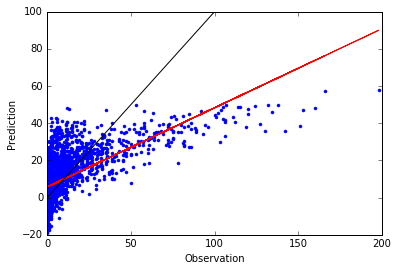

In [100]:
clf_LR=LR(X_cycle_train,X_cycle_test,y_cycle_train,y_cycle_test);
plot_comparision(predict(clf_LR,X_cycle_test),y_cycle_test,'test.pdf')

MSE on test data 41.8197604278
Mean squared error on training set using  RF 11.1838412094
Mean squared error on test set using   RF 41.8197604278
Slope =  [[ 0.88664831]]


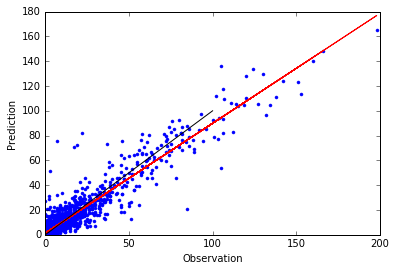

In [101]:
clf_RF=RF(X_cycle_train,X_cycle_test,y_cycle_train,y_cycle_test,20);
plot_comparision(predict(clf_RF,X_cycle_test),y_cycle_test,'test.pdf')

Mean squared error on training set using  DT 0.0
Mean squared error on test set using   DT 46.7319238901
Slope =  [[ 1.]]


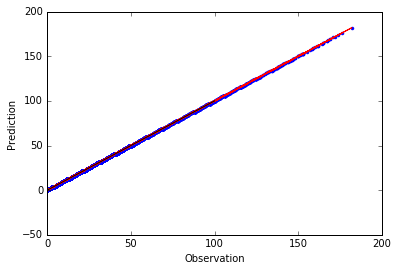

In [104]:
clf_DT=DT(X_cycle_train,X_cycle_test,y_cycle_train,y_cycle_test);
plot_comparision(predict(clf_DT,X_cycle_train),y_cycle_train,'test.pdf')

Shapes of y_test, y_prediction  (2365, 1) (2365, 1)
Mean squared error on training set using  ANN 31.4787914115
Mean squared error on test set using   ANN 47.5774457791
Slope =  [[ 0.89268701]]


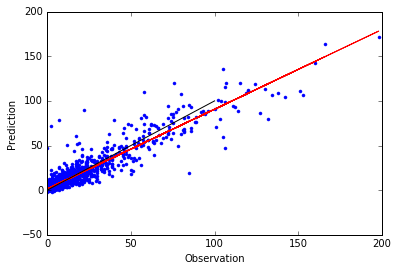

In [82]:
clf_ANN=ANN(X_cycle_train,X_cycle_test,y_cycle_train,y_cycle_test);
plot_comparision(predict(clf_ANN,X_cycle_test),y_cycle_test,'test.pdf')

Mean squared error on training set using  LR 121161.450876
Mean squared error on test set using   LR 122196.97475
Slope =  [[ 0.8023981]]


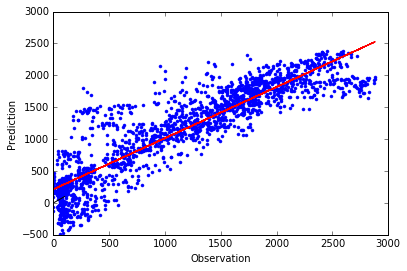

In [69]:
car_clf_LR=LR(X_car_train,X_car_test,y1_car_train,y1_car_test);
plot_comparision(predict(car_clf_LR,X_car_test),y1_car_test,'test.pdf')

MSE on test data 26401.8673825
Mean squared error on training set using  RF 12454.0225587
Mean squared error on test set using   RF 26401.8673825
Slope =  [[ 0.96351264]]


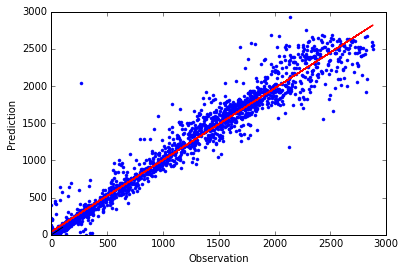

In [76]:
car_clf_RF=RF(X_car_train,X_car_test,y1_car_train,y1_car_test,max_depth=30);
plot_comparision(predict(car_clf_RF,X_car_test),y1_car_test,'test.pdf')

Mean squared error on training set using  DT 8189.67846735
Mean squared error on test set using   DT 28137.7182136
Slope =  [[ 0.97792803]]


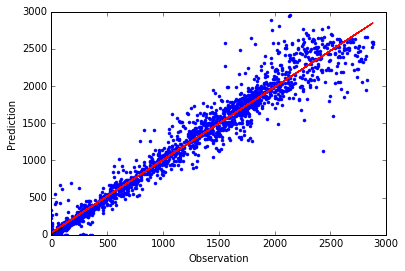

In [78]:
car_clf_DT=DT(X_car_train,X_car_test,y1_car_train,y1_car_test);
plot_comparision(predict(car_clf_DT,X_car_test),y1_car_test,'test.pdf')